100%|██████████| 141M/141M [00:16<00:00, 8.73MB/s] 


WARNING  'boxes' is deprecated and will be removed in 'ultralytics 8.399999999999999' in the future. Please use 'show_boxes' instead.

image 1/1 c:\Users\john\studium\Bachelorarbeit\YoloWorlSAMDemo\whales.jpg: 480x640 8 whales, 1635.2ms
Speed: 5.0ms preprocess, 1635.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict
1 label saved to runs\detect\predict\labels


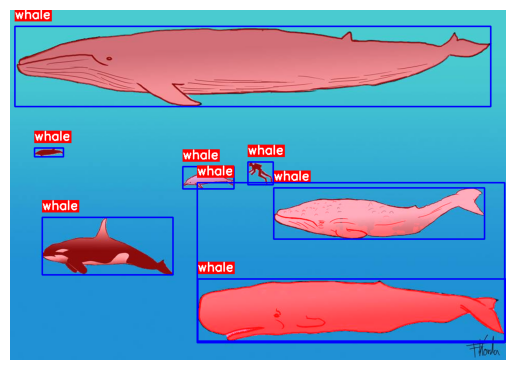

In [1]:
from ultralytics import YOLOWorld
import matplotlib.pyplot as plt
import cv2
import numpy as np
from segment_anything import sam_model_registry, SamPredictor


def detect_and_segment(img_name, classes):
    # Load the YOLO model and set classes
    yolo_model = YOLOWorld('yolov8x-world.pt')
    yolo_model.set_classes(classes)
    prediction_res = yolo_model.predict(source=img_name, save=True, save_txt=True, save_crop=True, boxes=True, conf=0.01)

    # Load SAM model
    sam_checkpoint = "sam_vit_h_4b8939.pth"
    model_type = "vit_h"
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    predictor = SamPredictor(sam)

    # Read the original image
    image = cv2.imread(img_name)
    height, width, channels = image.shape
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for SAM
    predictor.set_image(image_rgb)  # Set the image for segmentation

    # Get bounding boxes and class names from YOLO predictions
    bboxes = prediction_res[0].boxes.xyxy.tolist()
    class_ids = prediction_res[0].boxes.cls.tolist()  # Class IDs
    class_names = [classes[int(class_id)] for class_id in class_ids]  # Class names

    # Create a copy of the original image to draw masks on
    combined_image = image.copy()

    for box, class_name in zip(bboxes, class_names):
        input_box = np.array(box)

        # Predict mask for the bounding box
        masks, _, _ = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],
            multimask_output=False,
        )

        segmentation_mask = masks[0]

        # Convert the segmentation mask to a binary mask (0s and 1s)
        binary_mask = np.where(segmentation_mask > 0.5, 1, 0).astype(np.uint8)

        # Create a color for the mask (e.g., red with some transparency)
        color_mask = np.zeros_like(image)
        color_mask[:, :] = [0, 0, 255]  # Red color for the mask

        # Blend the mask with the original image using transparency
        alpha = 0.5  # Transparency factor
        masked_image = cv2.addWeighted(combined_image, 1, color_mask * binary_mask[..., np.newaxis], alpha, 0)

        # Update the combined image
        combined_image = masked_image

    # Save and display the result
    cv2.imwrite('result_with_labels.png', combined_image)
    return combined_image


img_name = "whales.jpg" # Set the path to your image here
classes = ['whale']# Set the classes Yolo world should detect here
result_image = detect_and_segment(img_name, classes)

# Display the result using matplotlib
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

